### Plan of Action
🧠 Step-by-Step Pipeline: Generalized Model + EA + XGBoost
1. Data Preparation
- Load OHLCV data for all selected tickers (e.g., AMZN, META, AVGO, ETFs)
- Normalize features per ticker (z-score or min-max scaling)
- Add metadata: ticker_id, sector, day_of_week, macro regime (optional)
- Create rolling windows for time series modeling (e.g., 10-day sequences)
2. Feature Engineering
- Technical indicators: RSI, MACD, Bollinger Bands, ATR
- Candle features: range, body size, wick ratios
- Volume features: OBV, VWAP, volume spikes
- Lagged returns, volatility, momentum scores




# 0. Dependencies

In [91]:
import yfinance as yf
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator, StochRSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator

## 1. Data Preparation
### Load OHLCV data for all selected tickers (e.g., AMZN, META, AVGO, ETFs)

Core Equity Holdings (NN Group, 2025)
- "AMZN", "META", "AVGO", "LLY", "ETN", "CYBR", "LIN", "WM", "SLNO", "CYTK"

ETF Additions (for sector/macro exposure)
- "SPY", "TLT", "LQD", "VNQ", "XLV"


Description:
- Amazon.com Inc – Consumer Discretionary
- Meta Platforms Inc – Communication Services
- Broadcom Inc – Technology
- Eli Lilly & Co – Healthcare
- Eaton Corp PLC – Industrials
- CyberArk Software Ltd – Technology
- Linde PLC – Materials
- Waste Management Inc – Industrials
- Soleno Therapeutics Inc – Healthcare
- Cytokinetics Inc – Healthcare
- SPDR S&P 500 ETF (SPY) – Broad Market ETF
- iShares 20+ Year Treasury ETF (TLT) – Government Bonds
- iShares Investment Grade Corporate Bond ETF (LQD) – Corporate Bonds
- Vanguard Real Estate ETF (VNQ) – Real Estate
- Health Care Select Sector SPDR ETF (XLV) – Healthcare Sector ETF

Based on Q2 2025 of Nationale-Nederlanden Powszechne Towarzystwo Emerytalne S.A.
https://www.sensamarket.com/institutional-investor/000201108125000008/compare/000201108125000005

In [3]:
tickers = ["AMZN", "META", "AVGO", "LLY", "ETN", "CYBR", "LIN", "WM", "SLNO", "CYTK", "SPY", "TLT", "LQD", "VNQ", "XLV"]
leadup_days = 0
start_date = (datetime.strptime("2015-01-01", "%Y-%m-%d") - timedelta(days=leadup_days)).strftime("%Y-%m-%d")
raw_data = yf.download(tickers, interval="1d", start=start_date, end="2025-01-01", group_by="ticker")

C:\Users\DLinger\AppData\Local\Temp\ipykernel_3968\4254150672.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(tickers, interval="1d", start=start_date, end="2025-01-01", group_by="ticker")
[*********************100%***********************]  15 of 15 completed


In [24]:
raw_data.columns

MultiIndex([('CYBR',   'Open'),
            ('CYBR',   'High'),
            ('CYBR',    'Low'),
            ('CYBR',  'Close'),
            ('CYBR', 'Volume'),
            ('CYTK',   'Open'),
            ('CYTK',   'High'),
            ('CYTK',    'Low'),
            ('CYTK',  'Close'),
            ('CYTK', 'Volume'),
            ('SLNO',   'Open'),
            ('SLNO',   'High'),
            ('SLNO',    'Low'),
            ('SLNO',  'Close'),
            ('SLNO', 'Volume'),
            ('META',   'Open'),
            ('META',   'High'),
            ('META',    'Low'),
            ('META',  'Close'),
            ('META', 'Volume'),
            ( 'VNQ',   'Open'),
            ( 'VNQ',   'High'),
            ( 'VNQ',    'Low'),
            ( 'VNQ',  'Close'),
            ( 'VNQ', 'Volume'),
            (  'WM',   'Open'),
            (  'WM',   'High'),
            (  'WM',    'Low'),
            (  'WM',  'Close'),
            (  'WM', 'Volume'),
            ( 'LQD',   'Open'),
        

## Technical Indicators
Momentum 
- RSI
- StochRSI

Trend
- MACD
- SMA
- EMA

Volatility
- BB (Bollinger Bands)
- ATR (Average True Range)

Volume
- OBV (On-Balance Volume)
- CMF (Chaikin Money Flow)

In [ ]:
"""
feature_engineering/
 ├── compute_indicators(df)
 ├── filter_redundant(df)
 ├── generate_signal(df, horizon=5)
 └── evaluate_signal(df)
 """

def compute_indicators(df):
    df = df.copy()
    
    # General price dynamics
    df["returns"] = df["Close"].pct_change()
    df["logReturns"] = np.log(df["Close"] / df["Close"].shift(1))
    df["Volatility"] = df["returns"].rolling(10).std()
    df['Range'] = df['High'] - df['Low']
    df['Body'] = abs(df['Close'] - df['Open'])
    df['Wick'] = df['Range'] - df['Body']

    # Momentum
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    df['StochRSI'] = StochRSIIndicator(df['Close'], window=14).stochrsi()
    
    # Short-term moving averages (faster response)
    df['SMA_10'] = SMAIndicator(df['Close'], window=10).sma_indicator()
    df['EMA_10'] = EMAIndicator(df['Close'], window=10).ema_indicator()

    # Medium-term moving averages (faster than previous 50)
    df['SMA_20'] = SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_20'] = EMAIndicator(df['Close'], window=20).ema_indicator()

    # Optional: slightly faster “long-term” averages for crossovers
    df['SMA_30'] = SMAIndicator(df['Close'], window=30).sma_indicator()
    df['EMA_30'] = EMAIndicator(df['Close'], window=30).ema_indicator()

    # Faster MACD for earlier crossovers
    macd = MACD(df['Close'], window_slow=13, window_fast=6, window_sign=5)
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    
    # Volatility
    bb = BollingerBands(df['Close'], window=20)
    df['BB_High'] = bb.bollinger_hband()
    df['BB_Low'] = bb.bollinger_lband()
    df['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
    
    # Volume
    df['OBV'] = OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
    df['OBV_prev'] = pd.to_numeric(df['OBV'].shift(1), errors='coerce').fillna(0).astype(int)
    df['CMF'] = ChaikinMoneyFlowIndicator(df['High'], df['Low'], df['Close'], df['Volume'], window=20).chaikin_money_flow()
    
    return df

In [48]:
# Example structure: df_multi.columns = MultiIndex([('CYBR', 'Open'), ('CYBR', 'High'), ...])

# Step 1: Convert MultiIndex columns to hierarchical format
df_stacked = raw_data.stack(level=0).swaplevel().sort_index()

# Step 2: Apply compute_indicators to each ticker group
results = []

for ticker, df_ticker in df_stacked.groupby(level=0):
    df_ticker = df_ticker.droplevel(0)  # Drop ticker level for compatibility
    df_ticker['Ticker'] = ticker        # Add ticker column for grouping inside compute_indicators
    df_indicators = compute_indicators(df_ticker)
    df_indicators['Ticker'] = ticker    # Ensure ticker is preserved
    results.append(df_indicators)

# Step 3: Concatenate results and set MultiIndex again
df_indicators = pd.concat(results)
df_indicators.set_index(['Ticker', df_indicators.index], inplace=True)


C:\Users\DLinger\AppData\Local\Temp\ipykernel_3968\3119526203.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_stacked = raw_data.stack(level=0).swaplevel().sort_index()


In [64]:
df_indicators = df_indicators.dropna().copy()
df_indicators.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF'],
      dtype='object', name='Price')

Problem 1: Overlapping or Redundant Indicators
What’s happening

Engine includes:

SMA and EMA for 10, 20, 30 bars,

multiple crossover versions (short, medium, long),

trend-following signals (MACD, RSI, StochRSI, CMF, OBV),

volatility filters (ATR, BB, Wick).

These all measure trend or momentum, but most are highly correlated.
When you sum weighted votes, they reinforce the same type of information multiple times.

In [61]:
def filter_redundant(df): 
    corr = df[['MACD', 'RSI', 'StochRSI', 'SMA_10', 'EMA_10', 'CMF', 'OBV']].corr().abs()
    redundant = set()
    for i in corr.columns:
        for j in corr.columns:
            if i != j and corr.loc[i, j] > 0.8:
                redundant.add(j)
    print("Highly correlated indicators:", redundant)
    df_filtered = df.drop(columns=list(redundant), errors='ignore')
    return df_filtered


In [ ]:
# df_filtered = filter_redundant(df_indicators)
# df_filtered.head()

Highly correlated indicators: {'SMA_10', 'EMA_10'}


Price                   Open       High        Low      Close    Volume  \
Ticker Date                                                               
AMZN   2015-02-13  18.920500  19.150000  18.850500  19.091499  69502000   
       2015-02-17  18.886000  18.999500  18.633499  18.771500  73464000   
       2015-02-18  18.688999  18.837000  18.642500  18.668501  53012000   
       2015-02-19  18.674500  19.094000  18.671499  18.950001  59076000   
       2015-02-20  18.931000  19.184999  18.792000  19.183001  65160000   

Price               returns  logReturns  Volatility     Range      Body  ...  \
Ticker Date                                                              ...   
AMZN   2015-02-13  0.012355    0.012279    0.011671  0.299500  0.171000  ...   
       2015-02-17 -0.016761   -0.016903    0.011511  0.366001  0.114500  ...   
       2015-02-18 -0.005487   -0.005502    0.011707  0.194500  0.020498  ...   
       2015-02-19  0.015079    0.014966    0.012345  0.422501  0.275501  ...   
       2015-02-20  0.012296    0.012221    0.010427  0.393000  0.252001  ...   

Price                 SMA_30     EMA_30      MACD  MACD_Signal    BB_High  \
Ticker Date                                                                 
AMZN   2015-02-13  16.289317  16.944235  0.684465     0.742694  20.424310   
       2015-02-17  16.400833  17.062123  0.595023     0.693470  20.518517   
       2015-02-18  16.519467  17.165760  0.501261     0.629400  20.528620   
       2015-02-19  16.658983  17.280872  0.463611     0.574137  20.561489   
       2015-02-20  16.801050  17.403590  0.454922     0.534399  20.647432   

Price                 BB_Low       ATR         OBV    OBV_prev       CMF  
Ticker Date                                                               
AMZN   2015-02-13  13.602739  0.483210  1240280000  1170778000  0.364288  
       2015-02-17  13.931983  0.481409  1166816000  1240280000  0.325835  
       2015-02-18  14.341530  0.460916  1113804000  1166816000  0.313352  
       2015-02-19  14.717410  0.458386  1172880000  1113804000  0.336824  
       2015-02-20  14.998168  0.453715  1238040000  1172880000  0.339321  

[5 rows x 25 columns]

In [163]:
def generate_signal(df, horizon=1, alpha=0.1, corr_threshold=0.85):
    """
    Modernized signal generation pipeline.
    Uses continuous signals, redundancy filtering, lag context, and data-driven weighting.
    
    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame with precomputed indicators and 'Close' price.
    horizon : int, optional
        How many bars ahead to predict returns (default=5).
    alpha : float, optional
        Regularization strength for Ridge regression.
    corr_threshold : float, optional
        Correlation cutoff for redundancy filtering.
    
    Returns:
    -------
    df : pd.DataFrame
        DataFrame with columns:
            - 'future_return'
            - 'alpha_signal'
            - 'expected_return'
    """

    df = df.copy()

    # === 1. Compute future returns (target variable) ===
    df['future_return'] = np.log(df['Close'].shift(-horizon) / df['Close'])

    # === 2. Select numeric indicator columns ===
    feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'returns', 'logReturns', 'Volatility', 'Range', 'Body', 'Wick',
    'RSI', 'StochRSI',
    'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30',
    'MACD', 'MACD_Signal',
    'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF'
    ]
    
    feature_cols = [c for c in feature_cols if c in df.columns]
    X = df[feature_cols].copy()

    # Drop missing rows
    X = X.dropna()
    y = df.loc[X.index, 'future_return']

    # === 3. Filter highly correlated (redundant) indicators ===
    corr = X.corr().abs()
    to_drop = set()
    for i in corr.columns:
        for j in corr.columns:
            if i != j and corr.loc[i, j] > corr_threshold:
                to_drop.add(j)
    if to_drop:
        print("Dropped redundant indicators:", to_drop)
        X = X.drop(columns=list(to_drop), errors='ignore')

    # === 4. Normalize features ===
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

    # === 5. Add temporal context (lags of each feature) ===
    lagged = []
    for lag in range(1, 4):  # last 3 bars of history
        lagged_df = X_scaled.shift(lag).add_suffix(f"_lag{lag}")
        lagged.append(lagged_df)
    X_full = pd.concat([X_scaled] + lagged, axis=1).dropna()

    y = y.loc[X_full.index].dropna()
    X_full = X_full.loc[y.index]  # Re-align X_full to match cleaned y


    # === 6. Train regression model to learn optimal indicator weights ===
    model = Ridge(alpha=alpha)
    model.fit(X_full, y)
    coefs = pd.Series(model.coef_, index=X_full.columns)

    # === 7. Compute predicted expected returns ===
    df['expected_return'] = np.nan
    df.loc[X_full.index, 'expected_return'] = model.predict(X_full)

    # === 8. Create a normalized signal ("alpha_signal") ===
    df['alpha_signal'] = np.tanh(df['expected_return'] / df['expected_return'].std())

    return df, model, coefs, X_full

In [164]:
df_signals, model, coefs, feature_matrix = generate_signal(df_indicators, horizon=5)

print(coefs.sort_values(ascending=False).head(10))
print("Predictive correlation:",
      df_signals[['alpha_signal', 'future_return']].corr().iloc[0,1])


Dropped redundant indicators: {'EMA_30', 'logReturns', 'OBV', 'High', 'EMA_10', 'Body', 'returns', 'Close', 'Open', 'Low', 'SMA_30', 'Wick', 'BB_Low', 'MACD_Signal', 'Range', 'OBV_prev', 'SMA_10', 'BB_High', 'SMA_20', 'EMA_20', 'MACD'}
Price
ATR_lag1           0.011224
ATR                0.004759
RSI_lag3           0.002866
Volatility         0.002584
CMF_lag2           0.002023
Volatility_lag1    0.001996
Volume_lag1        0.001637
StochRSI           0.001138
Volatility_lag3    0.000834
Volume             0.000690
dtype: float64
Predictive correlation: 0.05595421178822203


In [165]:
df_signals

Price                    Open        High         Low       Close    Volume  \
Ticker Date                                                                   
AMZN   2015-02-13   18.920500   19.150000   18.850500   19.091499  69502000   
       2015-02-17   18.886000   18.999500   18.633499   18.771500  73464000   
       2015-02-18   18.688999   18.837000   18.642500   18.668501  53012000   
       2015-02-19   18.674500   19.094000   18.671499   18.950001  59076000   
       2015-02-20   18.931000   19.184999   18.792000   19.183001  65160000   
...                       ...         ...         ...         ...       ...   
XLV    2024-12-24  136.813925  137.494888  136.231643  137.494888   3139300   
       2024-12-26  137.011293  137.889633  136.863249  137.771210   4720300   
       2024-12-27  137.011307  137.978465  136.547463  137.129730   5948000   
       2024-12-30  136.340191  136.340191  134.938795  135.442123   6890300   
       2024-12-31  135.777686  136.310605  134.998027  135.767822   6626900   

Price               returns  logReturns  Volatility     Range      Body  ...  \
Ticker Date                                                              ...   
AMZN   2015-02-13  0.012355    0.012279    0.011671  0.299500  0.171000  ...   
       2015-02-17 -0.016761   -0.016903    0.011511  0.366001  0.114500  ...   
       2015-02-18 -0.005487   -0.005502    0.011707  0.194500  0.020498  ...   
       2015-02-19  0.015079    0.014966    0.012345  0.422501  0.275501  ...   
       2015-02-20  0.012296    0.012221    0.010427  0.393000  0.252001  ...   
...                     ...         ...         ...       ...       ...  ...   
XLV    2024-12-24  0.004108    0.004100    0.009578  1.263246  0.680963  ...   
       2024-12-26  0.002010    0.002008    0.008882  1.026384  0.759917  ...   
       2024-12-27 -0.004656   -0.004667    0.008667  1.431002  0.118423  ...   
       2024-12-30 -0.012307   -0.012383    0.009362  1.401396  0.898067  ...   
       2024-12-31  0.002405    0.002402    0.008788  1.312579  0.009864  ...   

Price              MACD_Signal     BB_High      BB_Low       ATR         OBV  \
Ticker Date                                                                    
AMZN   2015-02-13     0.742694   20.424310   13.602739  0.483210  1240280000   
       2015-02-17     0.693470   20.518517   13.931983  0.481409  1166816000   
       2015-02-18     0.629400   20.528620   14.341530  0.460916  1113804000   
       2015-02-19     0.574137   20.561489   14.717410  0.458386  1172880000   
       2015-02-20     0.534399   20.647432   14.998168  0.453715  1238040000   
...                        ...         ...         ...       ...         ...   
XLV    2024-12-24    -1.556340  147.233936  133.060397  1.734866   743447100   
       2024-12-26    -1.333243  146.828264  132.882694  1.684260   748167400   
       2024-12-27    -1.137029  146.238979  132.747825  1.666170   742219400   
       2024-12-30    -1.047380  145.522348  132.526349  1.703653   735329100   
       2024-12-31    -0.985494  144.701933  132.466773  1.675720   741956000   

Price                OBV_prev       CMF  future_return  expected_return  \
Ticker Date                                                               
AMZN   2015-02-13  1170778000  0.364288      -0.004436              NaN   
       2015-02-17  1240280000  0.325835       0.008382              NaN   
       2015-02-18  1166816000  0.313352       0.031634              NaN   
       2015-02-19  1113804000  0.336824       0.015187         0.003070   
       2015-02-20  1172880000  0.339321      -0.009165         0.002415   
...                       ...       ...            ...              ...   
XLV    2024-12-24   740307800 -0.278458            NaN              NaN   
       2024-12-26   743447100 -0.289017            NaN              NaN   
       2024-12-27   748167400 -0.291774            NaN              NaN   
       2024-12-30   742219400 -0.304898            NaN           

In [166]:
model

,alpha,0.1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [167]:
coefs

Price
Volume             0.000690
Volatility         0.002584
RSI               -0.002873
StochRSI           0.001138
ATR                0.004759
CMF                0.000338
Volume_lag1        0.001637
Volatility_lag1    0.001996
RSI_lag1          -0.000388
StochRSI_lag1      0.000318
ATR_lag1           0.011224
CMF_lag1          -0.001179
Volume_lag2       -0.001380
Volatility_lag2   -0.004270
RSI_lag2          -0.001111
StochRSI_lag2     -0.000678
ATR_lag2          -0.010911
CMF_lag2           0.002023
Volume_lag3       -0.000297
Volatility_lag3    0.000834
RSI_lag3           0.002866
StochRSI_lag3      0.000007
ATR_lag3          -0.010250
CMF_lag3           0.000064
dtype: float64

In [168]:
feature_matrix

Price                Volume  Volatility       RSI  StochRSI       ATR  \
Ticker Date                                                             
AMZN   2015-02-19  1.306498   -0.183262  1.781329 -0.845314 -0.580521   
       2015-02-20  1.499861   -0.241392  1.929027 -0.388058 -0.581628   
       2015-02-23  0.812730   -0.221604  1.586573 -1.447348 -0.583774   
       2015-02-24  0.649878   -0.237867  1.436708 -1.447348 -0.587646   
       2015-02-25  1.446784   -0.205245  1.694539 -0.763205 -0.585324   
...                     ...         ...       ...       ...       ...   
XLV    2024-12-17 -0.244343   -0.384305 -2.268974 -1.447348 -0.317045   
       2024-12-18 -0.111874   -0.375935 -2.589284 -1.447348 -0.296876   
       2024-12-19 -0.191927   -0.382032 -2.738289 -1.447348 -0.294119   
       2024-12-20 -0.186553   -0.305214 -1.910432 -0.501806 -0.272260   
       2024-12-23 -0.315204   -0.276750 -1.345896  0.162649 -0.269284   

Price                   CMF  Volume_lag1  Volatility_lag1  RSI_lag1  \
Ticker Date                                                           
AMZN   2015-02-19  1.872764     1.113771        -0.202615  1.586868   
       2015-02-20  1.888202     1.306498        -0.183262  1.781329   
       2015-02-23  1.886463     1.499861        -0.241392  1.929027   
       2015-02-24  1.969631     0.812730        -0.221604  1.586573   
       2015-02-25  2.058294     0.649878        -0.237867  1.436708   
...                     ...          ...              ...       ...   
XLV    2024-12-17 -0.886062    -0.269880        -0.387838 -2.250378   
       2024-12-18 -1.529289    -0.244343        -0.384305 -2.268974   
       2024-12-19 -2.128884    -0.111874        -0.375935 -2.589284   
       2024-12-20 -2.412948    -0.191927        -0.382032 -2.738289   
       2024-12-23 -1.980693    -0.186553        -0.305214 -1.910432   

Price              StochRSI_lag1  ...  RSI_lag2  StochRSI_lag2  ATR_lag2  \
Ticker Date                       ...                                      
AMZN   2015-02-19       0.065748  ...  1.781256       0.591259 -0.575062   
       2015-02-20      -0.845314  ...  1.586868       0.065748 -0.579921   
       2015-02-23      -0.388058  ...  1.781329      -0.845314 -0.580521   
       2015-02-24      -1.447348  ...  1.929027      -0.388058 -0.581628   
       2015-02-25      -1.447348  ...  1.586573      -1.447348 -0.583774   
...                          ...  ...       ...            ...       ...   
XLV    2024-12-17      -1.447348  ... -1.912876      -1.447348 -0.333131   
       2024-12-18      -1.447348  ... -2.250378      -1.447348 -0.317802   
       2024-12-19      -1.447348  ... -2.268974      -1.447348 -0.317045   
       2024-12-20      -1.447348  ... -2.589284      -1.447348 -0.296876   
       2024-12-23      -0.501806  ... -2.738289      -1.447348 -0.294119   

Price              CMF_lag2  Volume_lag3  Volatility_lag3  RSI_lag3  \
Ticker Date                                                           
AMZN   2015-02-19  1.804806     1.637859        -0.203698  2.419359   
       2015-02-20  1.727607     1.763780        -0.208529  1.781256   
       2015-02-23  1.872764     1.113771        -0.202615  1.586868   
       2015-02-24  1.888202     1.306498        -0.183262  1.781329   
       2015-02-25  1.886463     1.499861        -0.241392  1.929027   
...                     ...          ...              ...       ...   
XLV    2024-12-17 -0.641373    -0.380558        -0.388110 -1.908568   
       2024-12-18 -0.553739    -0.329541        -0.399885 -1.912876   
       2024-12-19 -0.886062    -0.269880        -0.387838 -2.250378   
       2024-12-20 -1.529289    -0.244343        -0.384305 -2.268974   
       2024-12-23 -2.128884    -0.111874        -0.375935 -2.589284   

Price              StochRSI_lag3  ATR_lag3  CMF_lag3  
Ticker Date                                           
AMZN   2015-02-19       1.268429 -0.574635  2.042603  
       2015-02-20       0.591259 -0.575062  1.80

In [169]:
print(df_signals.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'returns', 'logReturns',
       'Volatility', 'Range', 'Body', 'Wick', 'RSI', 'StochRSI', 'SMA_10',
       'EMA_10', 'SMA_20', 'EMA_20', 'SMA_30', 'EMA_30', 'MACD', 'MACD_Signal',
       'BB_High', 'BB_Low', 'ATR', 'OBV', 'OBV_prev', 'CMF', 'future_return',
       'expected_return', 'alpha_signal'],
      dtype='object', name='Price')


In [170]:
def backtest_alpha_signal(df, signal_col='alpha_signal', return_col='future_return', threshold=0.2):
    df = df.copy().dropna(subset=[signal_col, return_col])

    # === 1. Define positions based on signal strength ===
    df['position'] = np.where(df[signal_col] > threshold, 1,
                       np.where(df[signal_col] < -threshold, -1, 0))

    # === 2. Calculate strategy returns ===
    df['strategy_return'] = df['position'] * df[return_col]

    # === 3. Compute cumulative returns ===
    df['cumulative_strategy'] = df['strategy_return'].cumsum()
    df['cumulative_market'] = df[return_col].cumsum()

    # === 4. Plot per-ticker performance ===
    if 'Ticker' in df.index.names:
        tickers = df.index.get_level_values('Ticker').unique()
        for ticker in tickers:
            df_t = df.loc[ticker].copy()
            df_t_plot = df_t.reset_index()
            plt.figure(figsize=(10, 5))
            plt.plot(df_t_plot['Date'], df_t_plot['cumulative_strategy'], label='Strategy')
            plt.plot(df_t_plot['Date'], df_t_plot['cumulative_market'], label='Market', linestyle='--')
            plt.title(f'Backtest: {ticker}')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Log Return')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # === 6. Performance metrics ===
    sharpe = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
    hit_rate = (df['strategy_return'] > 0).mean()
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Hit Rate: {hit_rate:.2%}")
    print(f"Total Return: {df['strategy_return'].sum():.4f}")

    return df



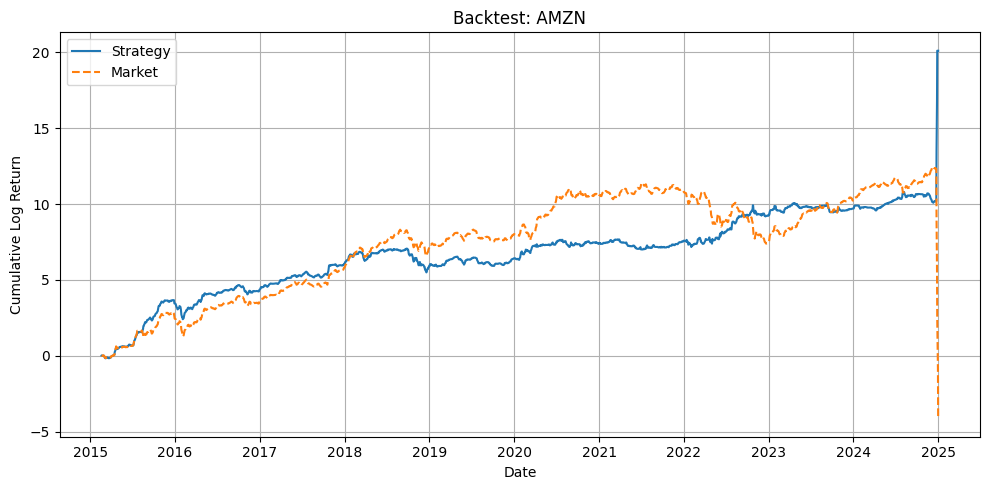

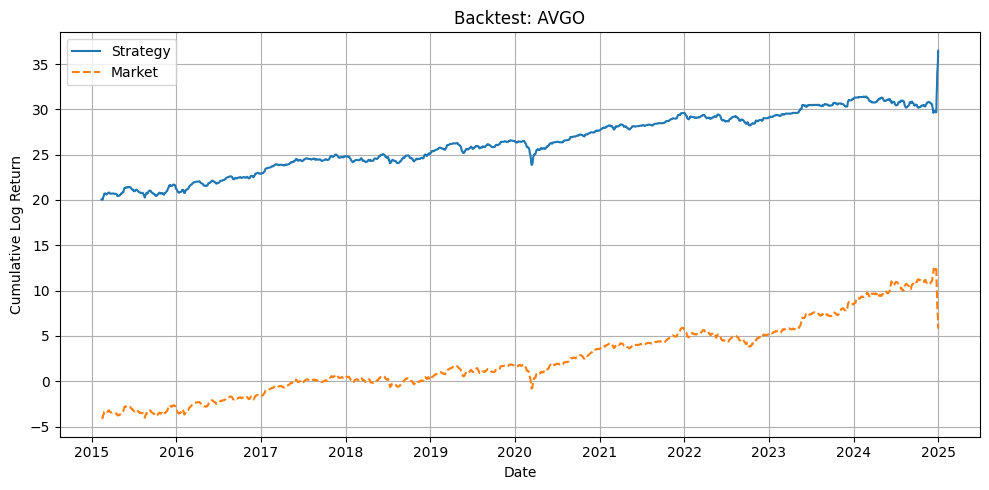

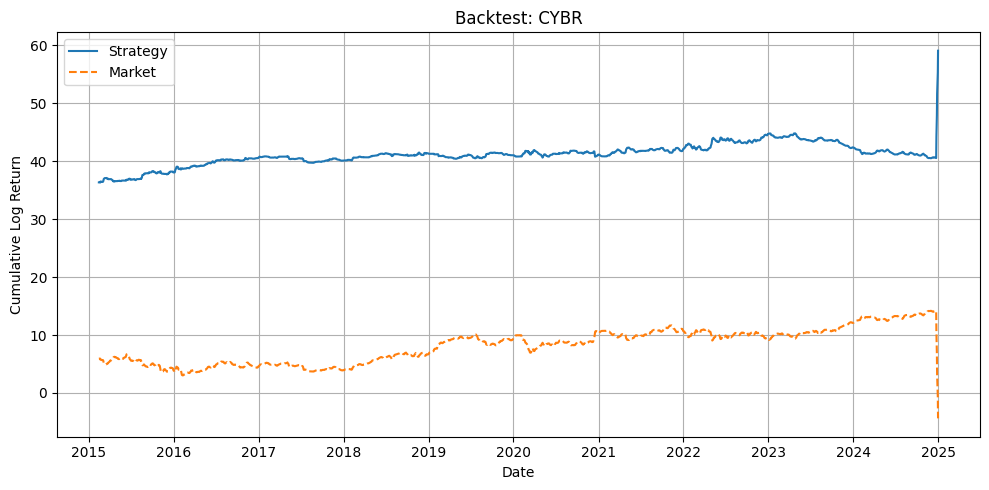

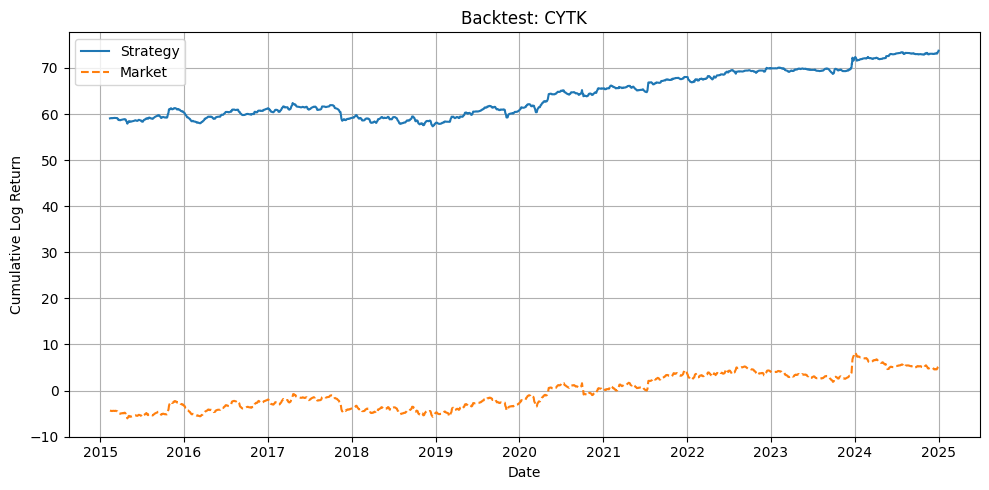

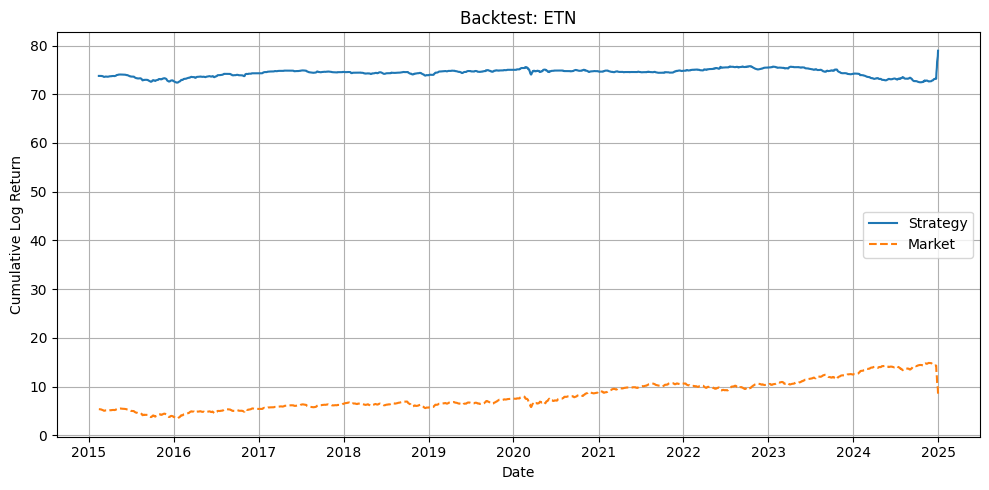

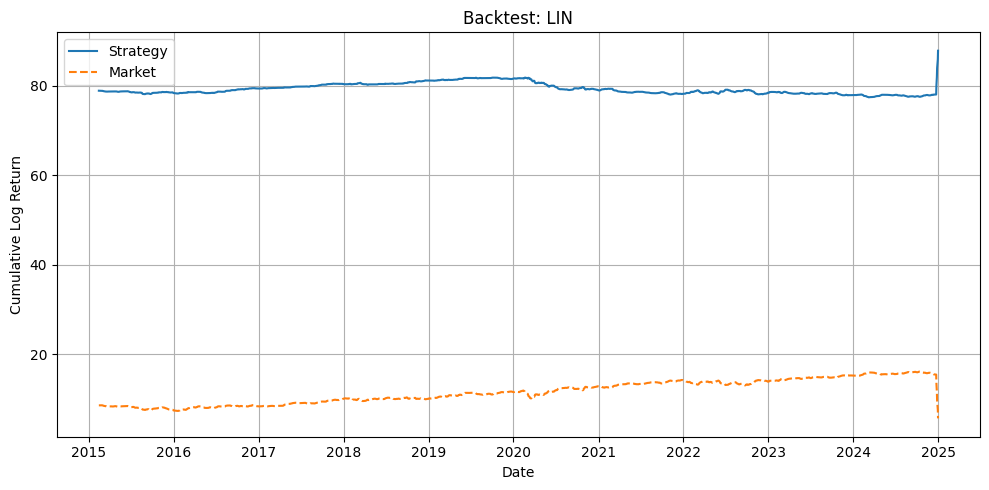

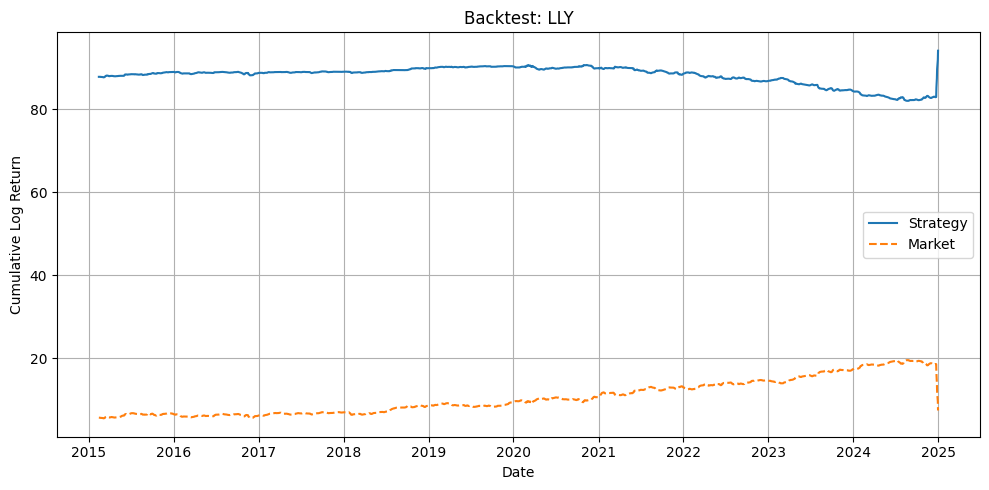

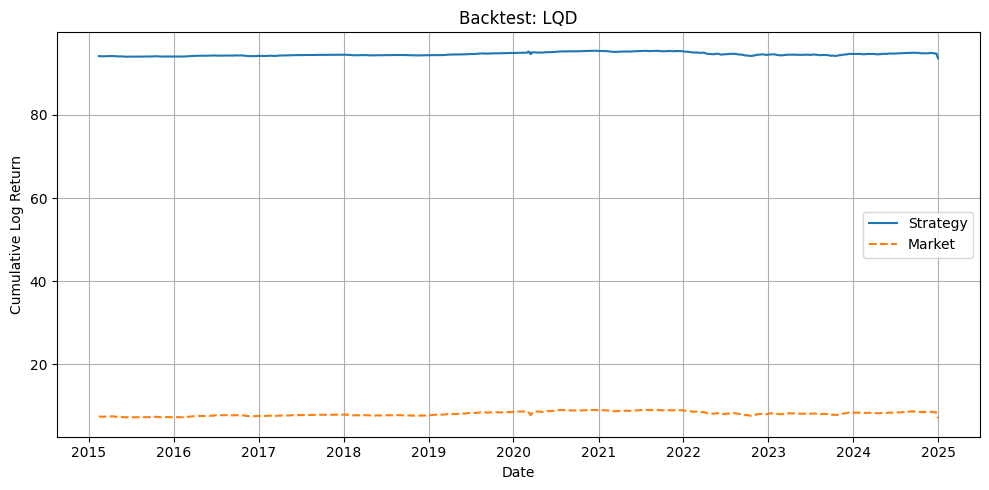

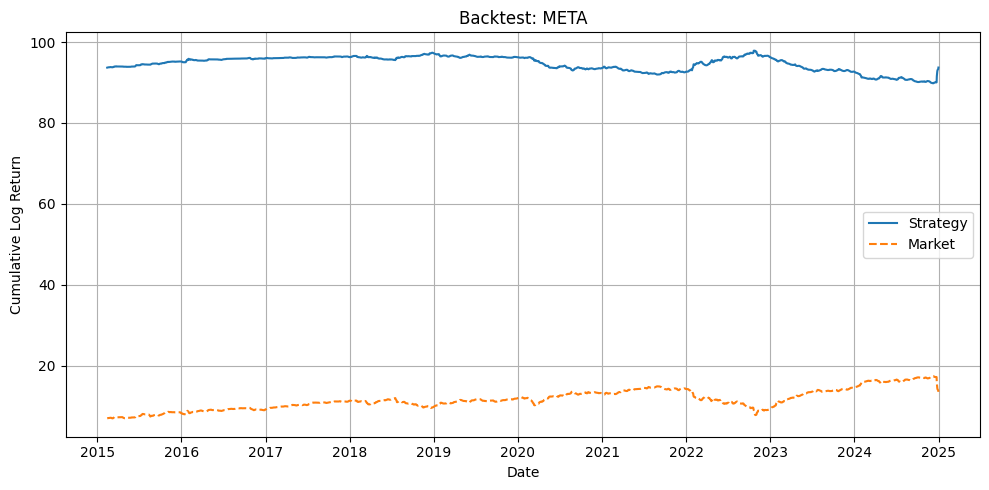

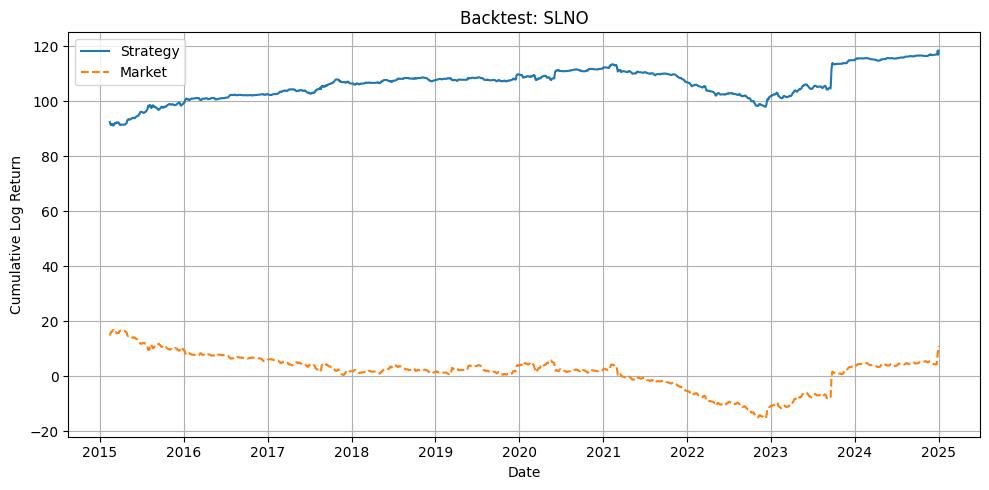

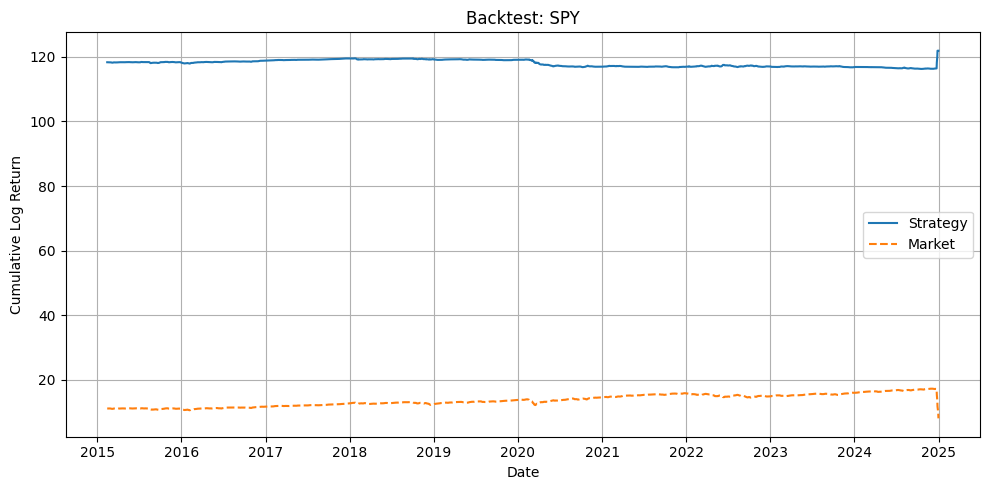

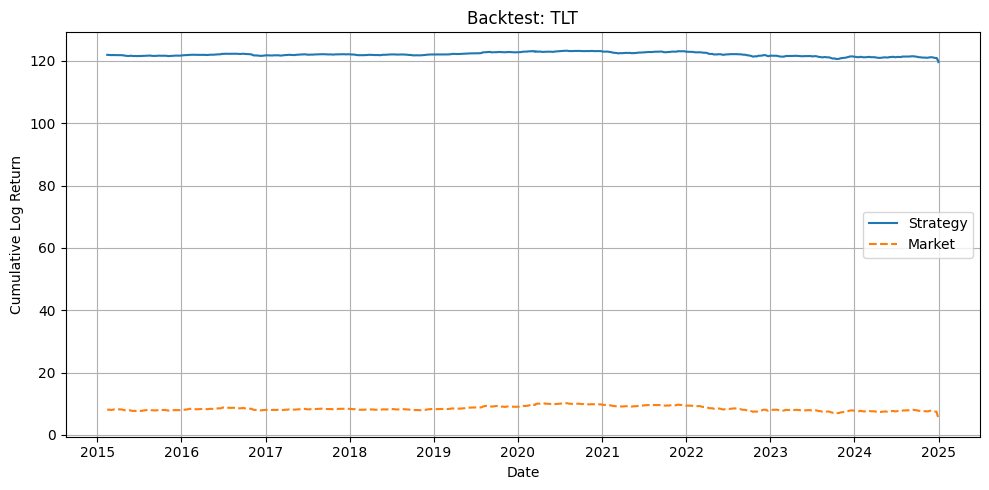

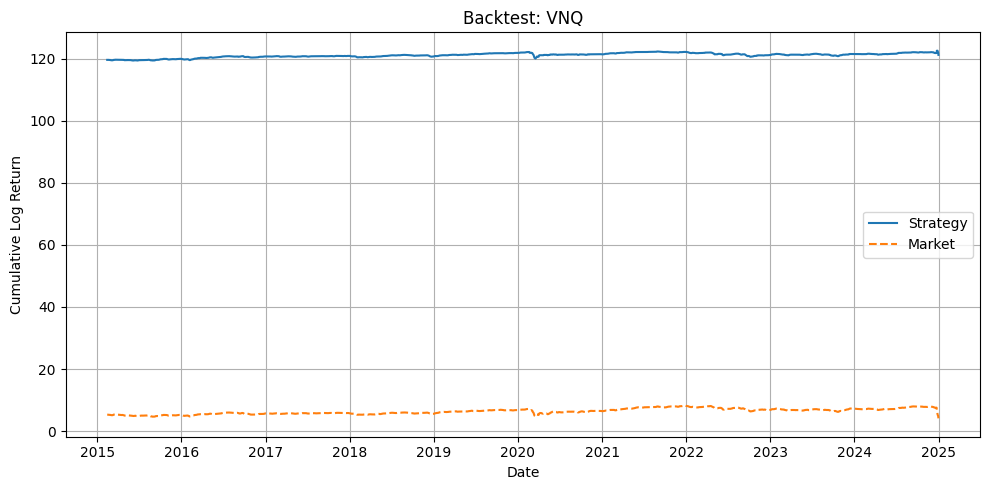

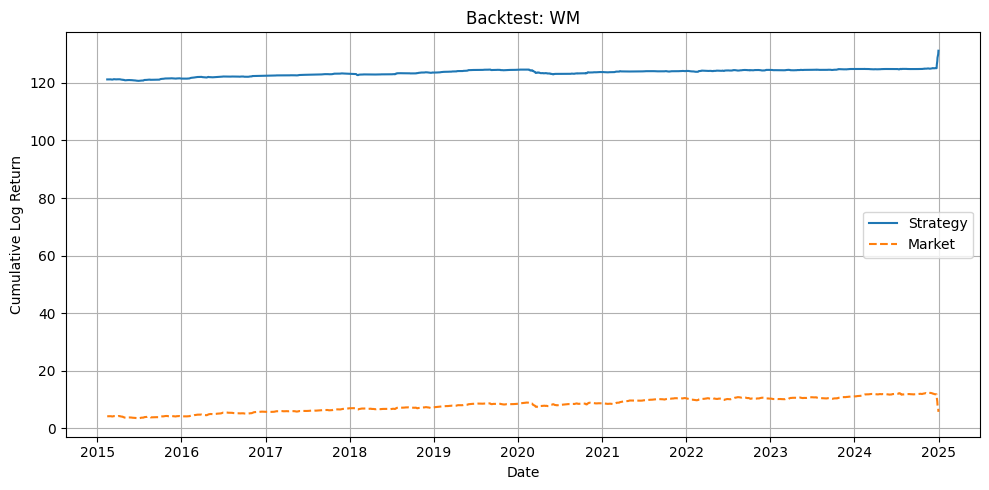

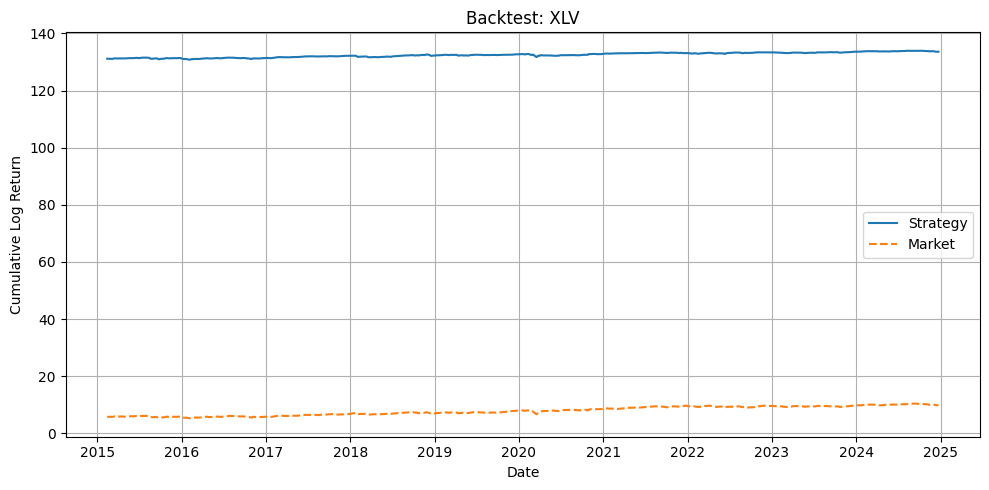

Sharpe Ratio: 0.65
Hit Rate: 38.48%
Total Return: 133.6204


Price                    Open        High         Low       Close    Volume  \
Ticker Date                                                                   
AMZN   2015-02-19   18.674500   19.094000   18.671499   18.950001  59076000   
       2015-02-20   18.931000   19.184999   18.792000   19.183001  65160000   
       2015-02-23   19.172001   19.226999   18.900000   19.007000  43540000   
       2015-02-24   18.932501   19.024000   18.808001   18.929501  38416000   
       2015-02-25   18.863501   19.392500   18.827000   19.268499  63490000   
...                       ...         ...         ...         ...       ...   
XLV    2024-12-17  136.266045  137.779029  136.167809  136.767105  10280100   
       2024-12-18  136.678664  137.582518  134.821831  134.910263  14448100   
       2024-12-19  134.654815  135.381835  133.564293  133.888504  11929300   
       2024-12-20  135.077278  136.845679  134.644997  135.578323  12098400   
       2024-12-23  135.797429  137.129735  135.195419  136.932358   8050500   

Price               returns  logReturns  Volatility     Range      Body  ...  \
Ticker Date                                                              ...   
AMZN   2015-02-19  0.015079    0.014966    0.012345  0.422501  0.275501  ...   
       2015-02-20  0.012296    0.012221    0.010427  0.393000  0.252001  ...   
       2015-02-23 -0.009175   -0.009217    0.011080  0.327000  0.165001  ...   
       2015-02-24 -0.004077   -0.004086    0.010543  0.216000  0.003000  ...   
       2015-02-25  0.017908    0.017750    0.011620  0.565500  0.404999  ...   
...                     ...         ...         ...       ...       ...  ...   
XLV    2024-12-17 -0.000718   -0.000718    0.005709  1.611220  0.501060  ...   
       2024-12-18 -0.013577   -0.013670    0.005985  2.760687  1.768401  ...   
       2024-12-19 -0.007574   -0.007602    0.005784  1.817541  0.766311  ...   
       2024-12-20  0.012621    0.012542    0.008320  2.200682  0.501045  ...   
       2024-12-23  0.009987    0.009938    0.009259  1.934315  1.134929  ...   

Price                     OBV    OBV_prev       CMF  future_return  \
Ticker Date                                                          
AMZN   2015-02-19  1172880000  1113804000  0.336824       0.015187   
       2015-02-20  1238040000  1172880000  0.339321      -0.009165   
       2015-02-23  1194500000  1238040000  0.339039       0.014417   
       2015-02-24  1156084000  1194500000  0.352488       0.015776   
       2015-02-25  1219574000  1156084000  0.366825      -0.006900   
...                       ...         ...       ...            ...   
XLV    2024-12-17   746536300   756816400 -0.109289       0.005307   
       2024-12-18   732088200   746536300 -0.213301       0.020985   
       2024-12-19   720158900   732088200 -0.310258       0.023920   
       2024-12-20   732257300   720158900 -0.356192      -0.001005   
       2024-12-23   740307800   732257300 -0.286295      -0.008541   

Price              expected_return  alpha_signal  position  strategy_return  \
Ticker Date                                                                   
AMZN   2015-02-19         0.003070      0.462513         1         0.015187   
       2015-02-20         0.002415      0.374589         1        -0.009165   
       2015-02-23         0.002053      0.322769         1         0.014417   
       2015-02-24         0.001103      0.177941         0         0.000000   
       2015-02-25         0.003749      0.545065         1        -0.006900   
...                            ...           ...       ...              ...   
XLV    2024-12-17         0.003675      0.536501         1         0.005307   
       2024-12-18         0.005322      0.700222         1         0.020985   
       2024-12-19         0.004996      0.672089         1         0.023920   
       2024-12-20         0.003084      0.464384         1        -0.001005   
       2024-12-23         0.000945      0.152838         0        -0.000

In [171]:
backtest_alpha_signal(df_signals)

#### Analyzing signal quality

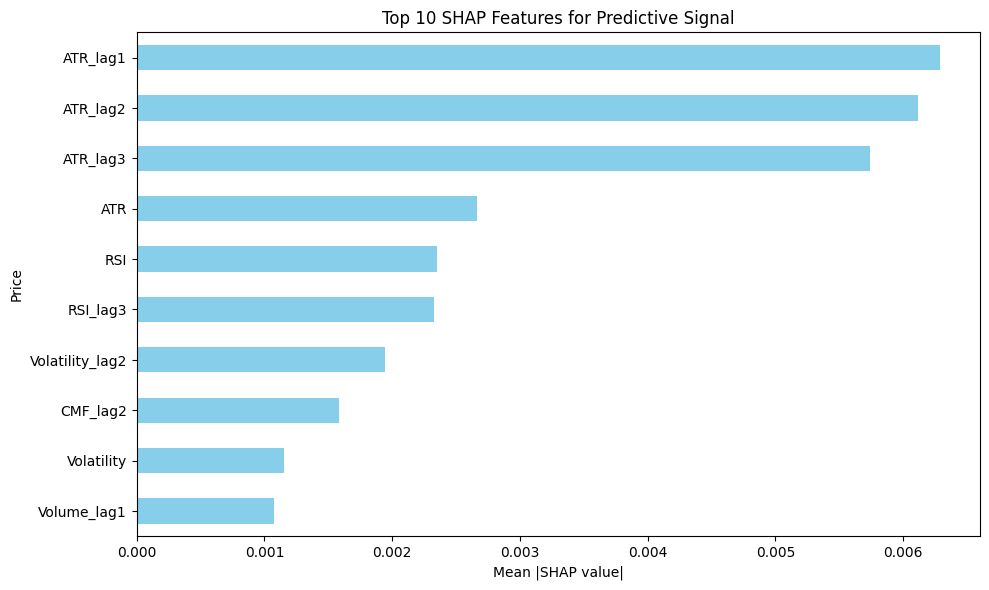

In [172]:

# === Assume you already have these ===
# model: trained Ridge model
# X_full: final feature matrix used for training (including lags)

# === 1. Create SHAP explainer for Ridge ===
explainer = shap.LinearExplainer(model, feature_matrix, feature_pertubation="independent")

# === 2. Compute SHAP values ===
shap_values = explainer.shap_values(feature_matrix)

# === 3. Calculate mean absolute SHAP value per feature ===
shap_importance = pd.Series(np.abs(shap_values).mean(axis=0), index=feature_matrix.columns)
top_features = shap_importance.sort_values(ascending=False).head(10)

# === 4. Plot top 10 SHAP features ===
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 SHAP Features for Predictive Signal")
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.show()


In [178]:
def backtest_per_ticker(df, signal_col='alpha_signal', return_col='future_return', threshold=0.2):
    results = []
    tickers = df.index.get_level_values('Ticker').unique()

    for ticker in tickers:
        df_t = df.loc[ticker].copy().dropna(subset=[signal_col, return_col])
        df_t['position'] = np.where(df_t[signal_col] > threshold, 1,
                             np.where(df_t[signal_col] < -threshold, -1, 0))
        df_t['strategy_return'] = df_t['position'] * df_t[return_col]
        df_t['cumulative_strategy'] = df_t['strategy_return'].cumsum()
        df_t['cumulative_market'] = df_t[return_col].cumsum()

        sharpe = df_t['strategy_return'].mean() / df_t['strategy_return'].std() * np.sqrt(252)
        hit_rate = (df_t['strategy_return'] > 0).mean()
        total_return = df_t['strategy_return'].sum()

        results.append({
            'Ticker': ticker,
            'Sharpe': sharpe,
            'HitRate': hit_rate,
            'TotalReturn': total_return
        })


    return pd.DataFrame(results).sort_values(by='Sharpe', ascending=False)



In [179]:
backtest_per_ticker(df_signals)

,Ticker,Sharpe,HitRate,TotalReturn
1,AVGO,1.375255,0.460796,16.376263
3,CYTK,1.125981,0.438279,14.654537
13,WM,1.102262,0.321271,9.972222
9,SLNO,1.071426,0.392441,24.660832
0,AMZN,1.064785,0.403382,20.089113
2,CYBR,0.828242,0.373945,22.625454
14,XLV,0.811566,0.372683,2.446614
5,LIN,0.623316,0.357861,8.933701
4,ETN,0.547310,0.339767,5.186481
6,LLY,0.380012,0.363892,6.290638


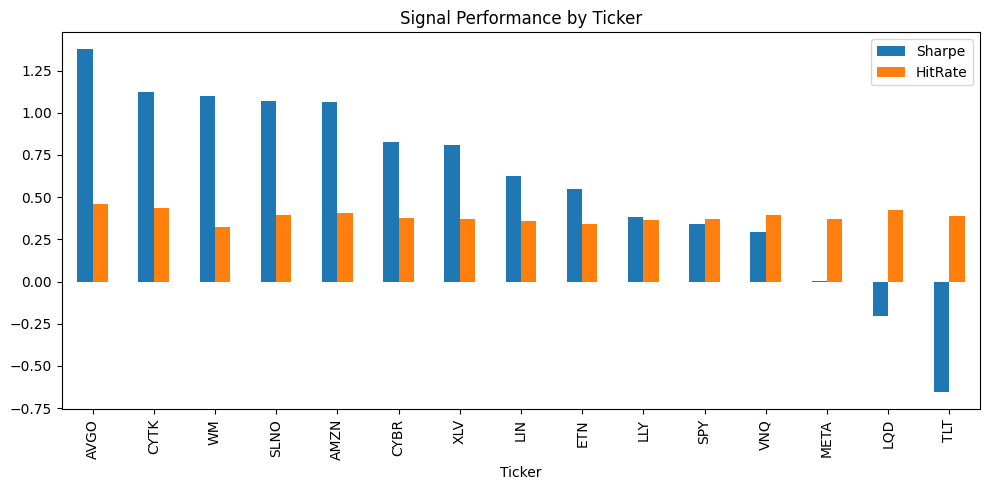

In [181]:
results = backtest_per_ticker(df_signals)
results.set_index('Ticker')[['Sharpe', 'HitRate']].plot(kind='bar', figsize=(10, 5), title='Signal Performance by Ticker')
plt.tight_layout()
plt.show()